In [112]:
# Useful imports and setup
import sys
import os
# Necessary to import code from ../scripts/
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/scripts")
    
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import numpy as np
import pandas as pd
import glob
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from preprocessing import preprocess


In [72]:
courses = ['analysenumerique_001',
 'analysenumerique_002',
 'analysenumerique_003',
 'cpp_fr_001',
 'dsp_001',
 'dsp_002',
 'dsp_004',
 'dsp_005',
 'dsp_006',
 'geomatique_003',
 'hwts_001',
 'hwts_002',
 'initprogcpp_001',
 'microcontroleurs_003',
 'microcontroleurs_004',
 'microcontroleurs_005',
 'microcontroleurs_006',
 'progfun_002',
 'progfun_003',
 'structures_001',
 'structures_002',
 'structures_003',
 'venture_001',
 'villesafricaines_001',
 'villesafricaines_002',
 'villesafricaines_003']

In [73]:
def get_feature_activations(norm, sparsity, percentile, X, x_train):
   
    meta = {'gumbel_temp': 1, 'gumbel_noise': 1e-8}
    model = MaskingModel(n_groups=x_train.shape[-1])

    filename = 'annealing_fg_'+norm+'_norm_'+str(sparsity)+'_perc_'+str(percentile)
    model.load_weights(MODEL_PATH + filename).expect_partial()

    masks = model.get_mask(X, meta)

    f_activated = tf.reduce_sum(masks, axis=0)
    f_activations = [(feature_names[i], f_activated[i].numpy()) for i in tf.where(f_activated)[:, 0]]
    
    return f_activations, masks

def get_cluster_features(labels, masks, feature_names, X, Y):
    
    clusters = {}
    for c in range(np.max(labels)+1):
        cluster = np.where(labels == c)[0]
        clusters[c] = {}
        clusters[c]['total_number_students'] = len(cluster)
        
        y_cluster = tf.gather(Y, list(cluster)).numpy()
        clusters[c]['total_number_pass_students'] = (y_cluster == 0).sum()
        clusters[c]['total_number_fail_students'] = (y_cluster == 1).sum()
        
        f_activated = tf.reduce_sum(tf.gather(masks, list(cluster)), axis=0)
        
        clusters[c]['features'] = {}
        for i in tf.where(f_activated)[:, 0]:
            # Select the indices that belong to the actual cluster and have feature 'i' activated
            a = np.where(masks[:, i] == 1)[0]
            a = list(set(a) & set(list(cluster))) 
            
            # Split the selected indices between pass/fail students
            target_0 = [j for j in a if Y[j] == 0]
            target_1 = [j for j in a if Y[j] == 1]
            
            clusters[c]['features'][feature_names[i]] = {}
            clusters[c]['features'][feature_names[i]]['number_students'] = f_activated[i].numpy()
            clusters[c]['features'][feature_names[i]]['avg_value'] = tf.reduce_mean(X[a, :, i]).numpy()
            clusters[c]['features'][feature_names[i]]['relative_value'] = tf.reduce_mean(X[a, :, i]).numpy()-tf.reduce_mean(X[:, :, i]).numpy()
            
            clusters[c]['features'][feature_names[i]]['number_pass_students'] = len(target_0)
            clusters[c]['features'][feature_names[i]]['avg_pass_value'] = tf.reduce_mean(X[target_0, :, i]).numpy()
            clusters[c]['features'][feature_names[i]]['relative_pass_value'] = tf.reduce_mean(X[target_0, :, i]).numpy()-tf.reduce_mean(X[:, :, i]).numpy()
            clusters[c]['features'][feature_names[i]]['number_fail_students'] = len(target_1)
            clusters[c]['features'][feature_names[i]]['avg_fail_value'] = tf.reduce_mean(X[target_1, :, i]).numpy()
            clusters[c]['features'][feature_names[i]]['relative_fail_value'] = tf.reduce_mean(X[target_1, :, i]).numpy()-tf.reduce_mean(X[:, :, i]).numpy()
            
    return clusters

The code below creates a table with all the information about clustering and the selected features for all configurations of normalization and sparsity targets tested using the first 4 weeks of each course.

In [74]:
percentile = 0.4
data_path = '../data/'
feature_types = ['lalle_conati', 'boroujeni_et_al', 'chen_cui', 'marras_et_al']
metadata = pd.read_csv(data_path + 'metadata.csv')
df = {}
df['course'] = []
df['number_students'] = []
df['norm'] = []
df['sparsity'] = []
df['max_features'] = []
df['average_features'] = []
df['features_for_all_students'] = []
df['train_bal_acc'] = []
df['val_bal_acc'] = []
df['test_bal_acc'] = []
df['f_activations'] = []
df['number_clusters'] = []
df['silhouette_score'] = []
df['clusters_labels'] = []
df['clusters_dict'] = []

for course in courses:
    results_path = '../results/' + course + '/inter-c3/'
    MODEL_PATH = '../models/saved/' + course + '/'
    path = data_path + course + '/'
    print(course)
    
    try:
        clusters = pd.read_pickle(results_path+'clusters_info.pkl')  
        
    except:
        continue
    
    norm_sparsity = {}
    norm_sparsity['unit'] = []
    norm_sparsity['min-max'] = []
    for f in glob.glob(MODEL_PATH+'*.index'):
        f = f.replace(MODEL_PATH, '').replace('.index', '').replace('annealing_fg_', '')
        f = f.split('_')
        if f[0] == 'unit' or f[0] == 'min-max':
            norm_sparsity[f[0]].append(float(f[2]))
    
    norm_sparsity['unit'].sort()
    norm_sparsity['min-max'].sort()
    
    for norm in norm_sparsity.keys():
        x_train, x_test, x_val, y_train, y_test, y_val, feature_names = preprocess(course, path, percentile, 
                                                                                   feature_types, metadata, 
                                                                                   normalization=norm)
        X = np.concatenate([x_train, x_val, x_test], axis=0)
        Y = np.concatenate([y_train, y_val, y_test], axis=0)
        
        clusters_per_norm = clusters[clusters['norm'] == norm]
        for sparsity in np.unique(norm_sparsity[norm]):
            
            clusters_per_sparsity = clusters_per_norm[clusters_per_norm['sparsity'] == sparsity]
            if len(clusters_per_sparsity) == 0:
                continue
                
            clusters_per_sparsity = clusters_per_sparsity.reset_index()
            
            f_activations, masks = get_feature_activations(norm, sparsity, percentile, X, x_train)
            
            df['course'].append(course)
            df['number_students'].append(X.shape[0])
            df['norm'].append(norm)
            df['sparsity'].append(sparsity)
            df['max_features'].append(len(f_activations))
            df['average_features'].append(np.mean(tf.reduce_sum(masks, axis=1).numpy()))
            count = 0
            for f, a in f_activations:
                if a/X.shape[0] == 1:
                    count += 1
            df['features_for_all_students'].append(count)
            
            scores = np.load(results_path+'scores_'+norm+'_norm_'+str(sparsity)+'.npy',allow_pickle='TRUE').item()
            df['train_bal_acc'].append(scores['train_bal_acc'][-1].numpy())
            df['val_bal_acc'].append(scores['val_bal_acc'][-1].numpy())
            
            test_acc = np.load(results_path+'test_acc_'+norm+'_norm_'+str(sparsity)+'.npy',allow_pickle='TRUE').item()
            df['test_bal_acc'].append(test_acc)
            
            df['f_activations'].append(f_activations)
            df['number_clusters'].append(clusters_per_sparsity['number_clusters'].tolist()[0])
            df['silhouette_score'].append(clusters_per_sparsity['silhouette_score'].tolist()[0])
            df['clusters_labels'].append(clusters_per_sparsity['labels'][0])

            df['clusters_dict'].append(get_cluster_features(clusters_per_sparsity['labels'][0], masks, 
                                                    feature_names, X, Y))
            


analysenumerique_001
analysenumerique_002
analysenumerique_003
cpp_fr_001
dsp_001
dsp_002
dsp_004
dsp_005
dsp_006
geomatique_003
hwts_001
hwts_002
initprogcpp_001
microcontroleurs_003
microcontroleurs_004
microcontroleurs_005
microcontroleurs_006
progfun_002
progfun_003
structures_001
structures_002
structures_003
venture_001
villesafricaines_001
villesafricaines_002
villesafricaines_003


In [77]:
df = pd.DataFrame(df)
pd.to_pickle(df, '../results/final_results.pkl') 

In [76]:
df

,course,number_students,norm,sparsity,max_features,average_features,features_for_all_students,train_bal_acc,val_bal_acc,test_bal_acc,f_activations,number_clusters,silhouette_score,clusters_labels,clusters_dict
0,analysenumerique_001,505,unit,0.54,2,1.380198,1,0.555843,0.473913,0.502717,"[(total_clicks_Video, 505.0), (time_between_se...",3,0.432570,"[0, 1, 2, 0, 0, 2, 0, 0, 0, 2, 0, 1, 0, 0, 2, ...","{0: {'total_number_students': 313, 'total_numb..."
1,analysenumerique_001,505,unit,0.55,3,3.000000,3,0.511169,0.521739,0.538043,"[(total_clicks_Video.Load, 505.0), (delay_lect...",3,0.185764,"[1, 0, 2, 0, 0, 0, 1, 0, 1, 2, 0, 0, 2, 0, 0, ...","{0: {'total_number_students': 286, 'total_numb..."
2,analysenumerique_001,505,unit,0.56,11,9.324753,8,0.577305,0.556522,0.597826,"[(weekly_prop_watched std, 505.0), (frequency_...",3,0.166189,"[2, 0, 1, 0, 2, 1, 2, 0, 2, 0, 0, 2, 0, 0, 0, ...","{0: {'total_number_students': 246, 'total_numb..."
3,analysenumerique_001,505,unit,0.58,16,15.782178,15,0.518243,0.717391,0.372283,"[(weekly_prop_watched std, 505.0), (weekly_pro...",6,0.242929,"[0, 4, 1, 4, 2, 1, 0, 4, 5, 4, 4, 0, 2, 0, 4, ...","{0: {'total_number_students': 80, 'total_numbe..."
4,analysenumerique_001,505,unit,0.60,22,20.837624,20,0.536487,0.508696,0.402174,"[(weekly_prop_replayed mean, 505.0), (weekly_p...",3,0.161103,"[0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, ...","{0: {'total_number_students': 316, 'total_numb..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,villesafricaines_002,3000,unit,0.55,6,6.000000,6,0.854912,0.851978,0.876628,"[(pause_duration std, 3000.0), (delay_lecture,...",4,0.531544,"[1, 0, 0, 1, 2, 1, 0, 1, 0, 1, 0, 2, 1, 0, 1, ...","{0: {'total_number_students': 1579, 'total_num..."
135,villesafricaines_002,3000,min-max,0.50,8,6.439667,6,0.898111,0.860885,0.938785,"[(total_clicks_Video.Load, 344.0), (weekly_pro...",3,0.719012,"[0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, ...","{0: {'total_number_students': 2624, 'total_num..."
136,villesafricaines_003,2153,unit,0.50,4,3.977705,3,0.853498,0.936247,0.826543,"[(delay_lecture, 2153.0), (time_between_sessio...",3,0.509528,"[1, 2, 2, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, ...","{0: {'total_number_students': 607, 'total_numb..."
137,villesafricaines_003,2153,unit,0.55,7,6.086855,6,0.872301,0.914958,0.861870,"[(total_clicks_Video, 187.0), (pause_duration ...",4,0.485607,"[0, 0, 1, 3, 2, 0, 3, 3, 0, 3, 0, 2, 0, 3, 0, ...","{0: {'total_number_students': 1060, 'total_num..."


In [129]:
best = {}
best['analysenumerique_002'] = 0.54
best['analysenumerique_003'] = 0.57 
best['cpp_fr_001'] = 0.6
best['dsp_001'] = 0.43
best['dsp_002'] = 0.5
best['dsp_004'] = 0.5
best['dsp_005'] = 0.5
best['dsp_006'] = 0.55
best['geomatique_003'] = 0.6
best['hwts_001'] = 0.55
best['hwts_002'] = 0.54
best['initprogcpp_001'] = 0.58
best['microcontroleurs_003'] = 0.56
best['microcontroleurs_004'] = 0.45
best['microcontroleurs_005'] = 0.5
best['microcontroleurs_006'] = 0.55
best['progfun_002'] = 0.45
best['venture_001'] = 0.55
best['villesafricaines_001'] = 0.5
best['villesafricaines_002'] = 0.5
best['villesafricaines_003'] = 0.5

In [130]:
df_importance = pd.DataFrame()
for i, (course, sparsity) in enumerate(zip(best, best.values())):
    c = df[df['course'] == course]
    c = c[c['norm'] == 'min-max']
    c = c[c['sparsity'] == sparsity]
   
    c = c.reset_index()
    
    f_activations = c['f_activations']
    n = c['number_students'][0]
    feature_importance = {}
    for f, x in f_activations[0]:
        feature_importance[f] = x/n
    aux = pd.DataFrame(feature_importance, index=[i])
    df_importance = pd.concat([df_importance, aux])

In [131]:
df_importance

,weekly_prop_watched mean,frequency_action_Video.Pause,time_sessions sum,time_between_sessions std,total_clicks_problem,time_in__video sum,competency_strength,competency_alignment,total_clicks_Video,regularity_peak_dayhour,...,total_clicks,student_speed,number_sessions,time_in__problem sum,total_clicks_Video.Load,pause_duration mean,delay_lecture,student_shape,weekly_prop_replayed std,frequency_action_Video.Stop
0,1.000000,0.595238,1.000000,0.611111,1.000000,0.910714,0.851190,1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1.000000,NaN,0.102397,NaN,NaN,1.000000,0.875817,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,0.581013,NaN,1.000000,1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,1.000000,NaN,1.000000,0.510248,NaN,NaN,...,0.331848,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN,...,NaN,1.000000,0.292904,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,0.009222,1.000000,NaN,1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,1.000000,0.001729,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,0.107486,1.000000,0.145489,1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,1.000000,0.345133,1.000000,NaN,NaN,NaN,...,0.003404,NaN,1.000000,1.000000,0.000681,0.140912,0.267529,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,0.738938,NaN,1.000000,1.000000,NaN,NaN,...,NaN,1.000000,0.068584,1.000000,NaN,NaN,NaN,0.584071,NaN,NaN
9,1.000000,0.496429,0.012857,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.523571,1.000000,NaN,NaN


In [132]:
df_importance = df_importance.fillna(0)

In [133]:
zero_data = np.zeros(shape=(len(df_importance), len(df_importance)))
cols = best.keys()
d = pd.DataFrame(zero_data, columns=cols)

data = []
for i in range(len(df_importance)):
    data.append(df_importance.iloc[i])

count = 0
for i in range(len(d)):
    for k,j in enumerate(d.columns):
        d[j][i] = stats.spearmanr(data[i], data[k])[0]

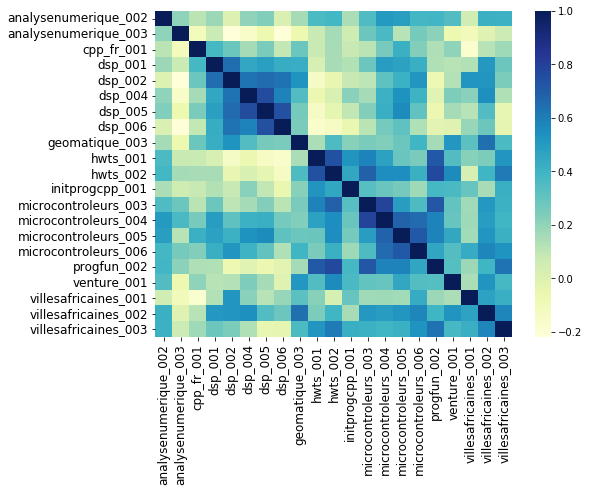

In [135]:
fig, ax = plt.subplots(figsize=(8, 6),facecolor='white')
g = sns.heatmap(d, fmt=".2f",ax=ax, cmap="YlGnBu")
l=list(np.arange(1,6+1))
g.xaxis.get_label().set_fontsize(14)
g.yaxis.get_label().set_fontsize(14)
g.set_xticklabels(best.keys(),rotation=90, fontsize=12)
g.set_yticklabels(best.keys(), rotation=0, fontsize=12)
plt.show()